Arima FS

In [162]:
import numpy as np
import pandas as pd
import os
import re
import warnings
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, KFold
from scripts.churn_functions import modernize, bake, simple_split, out_eval
from statsmodels.tsa.arima.model import ARIMA

In [391]:
class arima():
    def __init__(self):
        pass
    
    def fit(self,
            data,
            split,
            targetvar:str = 'n',
            feature_selection = None,
            order = (12, 1, 0)):
    
        # rewrite attributes
        self.data = data
        self.split = split
        self.targetvar = targetvar
        self.order = order

        """
        Runs ARIMA by split without exogenous regressors.
        targetvar is 'n' by default.
        order is (12, 1, 0) by default
        """
            
        X, y = data.drop(columns = targetvar), data[targetvar]

        X_train, X_test, y_train, y_test = simple_split(X, y, split)

        if feature_selection == None:
            exog = None
        else:
            exog = X_train
            
        scaling = Pipeline([
            ('scaler', StandardScaler())
            ])
        
        scaled_X = scaling.fit_transform(X_train, y_train)
        
        model = ARIMA(endog = y_train, 
#                     exog = scaled_X,
                      order = order)
                      
        self.model = model.fit()
        
        self.__X_train__ = X_train
        self.__y_train__ = y_train
        self.__X_test__ = X_test
        self.__y_test__ = y_test
    def predict(self, ahead = 3):

        # Store the fitted values with the same time index as the training data
        train_pred = pd.Series(self.model.predict(), index= self.__X_train__.index)

        # test prediction
        test_pred = pd.Series(self.model.predict(start = self.__X_test__.index.min(),
                                                 end = self.__X_test__.index.max()), index = self.__X_test__.index)

        # X_modern = modernize(list(self.__X_train__.columns), ahead = ahead)
        
        pred = self.model.predict(start = self.__X_test__.index.max() + 1,
                                 end = self.__X_test__.index.max() + ahead)

        self.full = bake(self.__y_train__, self.__y_test__, train_pred, test_pred, pred)

In [13]:
os.chdir('C:\\Users\\keato\\Documents\\LocalRStudio\\LJ_Leading_Indicators')
data = pd.read_csv("data/out/features.csv")

In [392]:
a = arima()

In [396]:
a.fit(data, split = 135, order = (12, 1, 0), feature_selection=True)

148

In [401]:
#with 6-month season, 3713 mse
a.predict(ahead = 3)

Train: 2241.953013175777 
Test: 2836.4694083786376


(2241.953013175777, 2836.4694083786376)

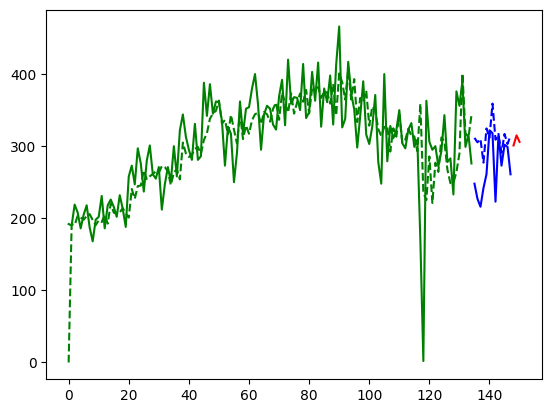

In [402]:
from sklearn.metrics import mean_squared_error
out_eval(a.full, criterion = mean_squared_error, verbose=2)

In [390]:
a.full

,actual,pred,group
0,192.0,0.000000,train
1,190.0,191.664480,train
2,219.0,190.459057,train
3,208.0,201.735161,train
4,186.0,197.455673,train
...,...,...,...
147,261.0,213.795001,test
148,NaN,225.150433,pred
149,NaN,231.290881,pred
150,NaN,217.266535,pred
